In [2]:
#Question 1
import numpy as np
import pandas as pd
import pickle
from collections import Counter
from multiprocessing.pool import Pool
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')
tokens = df['Email Text'].str.split()
tokens.head()

0    [re, :, 6, ., 1100, ,, disc, :, uniformitarian...
1    [the, other, side, of, *, galicismos, *, *, ga...
2    [re, :, equistar, deal, tickets, are, you, sti...
3    [Hello, I, am, your, hot, lil, horny, toy., I,...
4    [software, at, incredibly, low, prices, (, 86,...
Name: Email Text, dtype: object

In [ ]:
# I would look for common characters in all emails universially and seek to remove them, thigs like periods, commas, along with common words or phares to any email no matter what the intention, scam or not so the remaining values that do occur with some frequency higher than one could be analyzed. I would then take some known phishing email scam and write a program to see which words commonly occur amongst those emails, and compare that list to this group of emails and iterate through to flag ones with suspected key words that correlate to a scam.  

<Axes: >

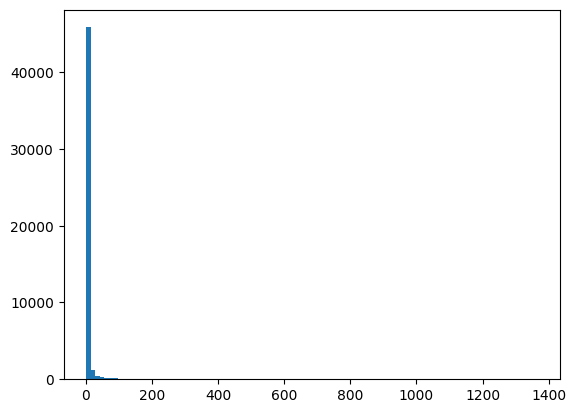

In [3]:
#Question 2
with open('all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)
    
from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

gdf = pd.DataFrame(token_freq,columns=['token','count'])
gdf['count'].hist(grid=False,bins=100)

In [4]:
gdf['count'].describe()

count    48691.000000
mean         5.687889
std         27.717476
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       1365.000000
Name: count, dtype: float64

In [7]:
most_frequent_word = token_freq[0]
print(most_frequent_word)

('new', 1365)


In [ ]:
#These results are interesting, only one token occurs significantly more frequently than others, everything within the 75th percentile (fast majority of the tokens) do not occur more than twice (possibly even in the same email). The outlier word used most frequently is the word new, which in terms of scam emails is interesting as many different types of scams begin or involve a victim believing they are getting a good deal on some knid of new item if they pay the scammer directly. 

In [16]:
#Part 3 Loading the data 
df = pd.read_parquet('Phishing_clean.parquet')

In [17]:
#Part 3 80/20 split 
y = df['Email Type']
X = df.drop('Email Type',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=125)

In [18]:
#Part 3 Regression, R-squared terms 
lm_0 = LinearRegression(fit_intercept=False).fit(X_train,y_train)
y_hat_test_0 = lm_0.predict(X_test)
y_hat_train_0 = lm_0.predict(X_train)
print('train: ', r2_score(y_hat_train_0,y_train) )
print('test: ', r2_score(y_hat_test_0,y_test) )    

train:  0.6162534357433663
test:  -0.0002683843266513275


In [ ]:
#The test subset has a much lower R-squared value than the one for the smaller training subset of data which is ~ 0.62 (fairly good), but when applied to the text set does not seem to have much predictive value at all. 

In [25]:
#Part 3 most common tokens 
rdf = pd.DataFrame({
    'variable': lm_0.feature_names_in_,
    'value': lm_0.coef_})
rdf_sorted = rdf.assign(abs_value = rdf['value'].abs()).nlargest(len(rdf), 'abs_value')

print(rdf_sorted)

     variable         value     abs_value
33       2001  1.090207e+13  1.090207e+13
74      2002, -1.084084e+13  1.084084e+13
710      1997 -1.001920e+13  1.001920e+13
1721      06,  9.410411e+12  9.410411e+12
1998      7.3  8.951357e+12  8.951357e+12
...       ...           ...           ...
91       july  2.145767e-04  2.145767e-04
319     thing  1.678467e-04  1.678467e-04
557      half  8.392334e-05  8.392334e-05
1867    index -8.368492e-05  8.368492e-05
2642      301 -1.387779e-17  1.387779e-17

[2711 rows x 3 columns]


In [ ]:
#From these values most of the highest reported tokens are numbers which don't have much meaning in terms of being present in scam emails or not to my knowledege.

<Axes: >

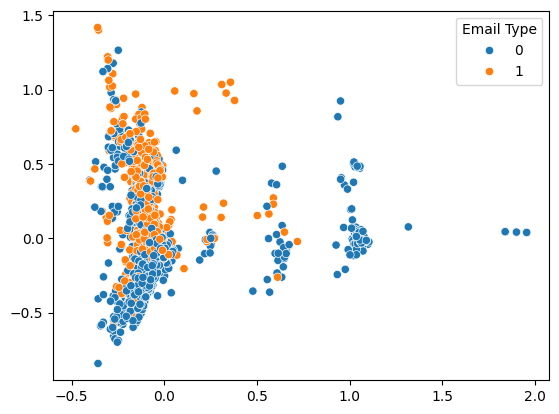

In [26]:
#Part 4 one-hot encoded scatter plot 
reduction = PCA(n_components=2).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)
sns.scatterplot(x=Z_test[:,0],y=Z_test[:,1],hue=y_test)

In [ ]:
#The orange dots so denoted as 1 in the code were actual scam emails and the blue dots encoded with a 0 were normal, non-scam emails. There does seem to be some separation between the groups, non scam emails have some distinct clusters, but theres is a lot of overlap as well. 

In [27]:
#Part 5 Regression based on the principal componenets of X 
reduction = PCA(n_components=2610).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)

lm_k = LinearRegression().fit(Z_train,y_train)
y_hat_test = lm_k.predict(Z_test)
y_hat_train = lm_k.predict(Z_train)

print('Train r2: ', r2_score(y_hat_train,y_train) )
print('Test r2: ', r2_score(y_hat_test,y_test) )  

Train r2:  0.6928975360963752
Test r2:  0.5873905973217183


In [ ]:
#The training R squared value is very similar to the training R squared from the linear regression in part 3, however when it is actually applied to the test set this regression's R squared value reamins close to .6 meaning it is a lot more effective at capturing and predicting a good amount of the variation in the data and consquently whether an email is a scam or not.

In [ ]:
#Part 6 explain the advantages/drawbacks to PCA approach in this context 
# The advantage with emails like this is that both scam emails and ordinary ones have a large number of components (tokens for each word/number) and many of those values will overlap with one another simply because sentences use many of the same words regardless of their end meaning/intention. PCA breaks these down to the components that have the most influence on whether the email was a scam or not, and uses only those to run a regression which eliminates some of the non consquential components that make the model less effective in predicting the categorical outcome because of so much multicollinearity between some of the tokens in both scam and non-scam emails. The PCA approach was proved to create a much better model (Part 5 as opposed to part 3),  